### _This document will be reviewing the variational quantum eigensolver (VQE) and it applications in chemistry when calculating the ground state energy. Before we can use the VQE we have to define chemically relavent Hamiltonians and wave functions for molecules with a given basis set functions. Throughout this document the Born-Oppenheimer will be used, only the electronic Hamiltonian and the electrons wave functions will be considered._

In [1]:
from qiskit import *
import numpy as np

# **Define Molecules**

#### The first part of this document will be regarding how to define the geometry of molecules and their associated fermionic and qubit Hamitlonians. Using ase geometry for each atom of a molecule are found in their equilabrium position. However, to find the associated Hammiltonians the information is then transformed into a Qiskit format using MoleculeInfo from Qiskit Nature. Below is a function which gives the geomtry of a molecule given its chemical symbol, e.g. "H2" and "LiH".

In [2]:
from ase.build import molecule
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

def qiskit_molecule(name_of_molecule):
    ''' 
    Given molecule (e.g. "H2", "LiH" etc.) name returns molecule information in Qiskit format
    '''
    ase_molecule = molecule(name_of_molecule) 
    
    atom_list = ase_molecule.get_chemical_symbols()
    
    position_list = ase_molecule.positions
    
    qiskit_molecule = MoleculeInfo(atom_list, position_list)
    
    return qiskit_molecule

#### A complete list of molecules included in this package can be found running the following cell

In [3]:
from ase.collections import g2

print(g2.names)

['PH3', 'P2', 'CH3CHO', 'H2COH', 'CS', 'OCHCHO', 'C3H9C', 'CH3COF', 'CH3CH2OCH3', 'HCOOH', 'HCCl3', 'HOCl', 'H2', 'SH2', 'C2H2', 'C4H4NH', 'CH3SCH3', 'SiH2_s3B1d', 'CH3SH', 'CH3CO', 'CO', 'ClF3', 'SiH4', 'C2H6CHOH', 'CH2NHCH2', 'isobutene', 'HCO', 'bicyclobutane', 'LiF', 'Si', 'C2H6', 'CN', 'ClNO', 'S', 'SiF4', 'H3CNH2', 'methylenecyclopropane', 'CH3CH2OH', 'F', 'NaCl', 'CH3Cl', 'CH3SiH3', 'AlF3', 'C2H3', 'ClF', 'PF3', 'PH2', 'CH3CN', 'cyclobutene', 'CH3ONO', 'SiH3', 'C3H6_D3h', 'CO2', 'NO', 'trans-butane', 'H2CCHCl', 'LiH', 'NH2', 'CH', 'CH2OCH2', 'C6H6', 'CH3CONH2', 'cyclobutane', 'H2CCHCN', 'butadiene', 'C', 'H2CO', 'CH3COOH', 'HCF3', 'CH3S', 'CS2', 'SiH2_s1A1d', 'C4H4S', 'N2H4', 'OH', 'CH3OCH3', 'C5H5N', 'H2O', 'HCl', 'CH2_s1A1d', 'CH3CH2SH', 'CH3NO2', 'Cl', 'Be', 'BCl3', 'C4H4O', 'Al', 'CH3O', 'CH3OH', 'C3H7Cl', 'isobutane', 'Na', 'CCl4', 'CH3CH2O', 'H2CCHF', 'C3H7', 'CH3', 'O3', 'P', 'C2H4', 'NCCN', 'S2', 'AlCl3', 'SiCl4', 'SiO', 'C3H4_D2d', 'H', 'COF2', '2-butyne', 'C2H5', 'BF3'

## _Defining molecules exercises_

### *Exercise 1*
#### Define H2 and print the list of atoms and the geometry of the molecule. Does it make sense? _Hint: use print_

In [4]:
H2_molecule = qiskit_molecule("H2")

print(H2_molecule)

Molecule:
	Multiplicity: 1
	Charge: 0
	Unit: Angstrom
	Geometry:
		H	[0.       0.       0.368583]
		H	[ 0.        0.       -0.368583]


### *Exercise 2*

#### Define 2 other molecules of your choice and understand their geometry.

In [5]:
molecule_LiH = qiskit_molecule("LiH")

print(molecule_LiH)

Molecule:
	Multiplicity: 1
	Charge: 0
	Unit: Angstrom
	Geometry:
		Li	[0.   0.   0.41]
		H	[ 0.    0.   -1.23]


In [6]:
molecule_CH4 = qiskit_molecule("CH4")

print(molecule_CH4)

Molecule:
	Multiplicity: 1
	Charge: 0
	Unit: Angstrom
	Geometry:
		C	[0. 0. 0.]
		H	[0.629118 0.629118 0.629118]
		H	[-0.629118 -0.629118  0.629118]
		H	[ 0.629118 -0.629118 -0.629118]
		H	[-0.629118  0.629118 -0.629118]


### *Exercise 3*

#### What parameter is locked when the molecules are defined like this? How does it simplify the problem of finding the ground state of a molecule?

#### The nuclei's momentum is locked, such that the Born-Oppenheimer approximation can be used. Therefore their kinetic energy is not a part of the Hamiltonian and the nuclei-nuclei repulsion can be added as constant term in the end.

### _Exercise 4_

#### The molecules come with predefined positions for the atoms that correspond to their equilibrium position. Can you define a molecule with too short or too long bond lengths compared to the equilibrium position?

In [7]:
ase_molecule = molecule("H2")

atom_list = ase_molecule.get_chemical_symbols()

stretch = 2 #Here you can define how stretched the molecule is
position_list = ase_molecule.positions*stretch #Strect multiplied

H2stretchqiskit = MoleculeInfo(atom_list,position_list)

print(H2stretchqiskit)

Molecule:
	Multiplicity: 1
	Charge: 0
	Unit: Angstrom
	Geometry:
		H	[0.       0.       0.737166]
		H	[ 0.        0.       -0.737166]


# **Fermionic Hamiltonian**

#### The fermionic Hamiltonian is described in the second quantization when using qiskit, the electronic Hamiltonian in the second quantization is given by,
#### $\hat{H}_{e} = \sum_{i, j}h_{ij}\hat{a}_i^\dagger \hat{a}_j + \sum_{p, q, r, s} g_{pqrs} \hat{a}_p^\dagger \hat{a}_q^\dagger \hat{a}_r \hat{a}_s$

#### It is split into one electron interactions and two electron interactions, where the constant $h_{ij}$ is some integral describing one electron interacions and the constant $g_{pqrs}$ is some integral describing the two integral interactions. The operators $a_i$ and $a_j^\dagger$ correspond to the annihilation and creation operators, which either creates or annihilates an electron in a given orbital. Summing over all the orbitals for both the one electron and two electron interactions then gives the electronic Hamiltonian.


#### The fermionic Hamiltonian can be defined using the geometry of a molecule in the format introduced above. However, it is also necessary to determine which basis set functions the Hamiltonian should include, this topic we will return to later, for now let us simply use the STO-3G basis set. For large molecules it is computationally advantagoues to restrict the size of the active space, that is how many electron which are active in the interaction essentially freezing the rest, again this we will return to later. Below a function which calculates the fermionic Hamitlonian is defined, it takes the name of a molecule as its input and have two optional inputs, the basis set and the active space transformation (as_transform) which are set to be in the STO-3G basis and using the full space as default. The function returns both the fermionic Hamiltonian and a electronic structure problem, which is used to calculate the exact energy later.

In [7]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

def fermionic_hamiltonian_func(name_of_molecule, basis = 'sto3g', as_transform = 0):
    '''
    Calculates the fermionic Hamiltonian and electronic structure problem given molecule name.
    Default settings of basis = STO-3G and full active space.
    '''
    
    qiskitmolecule = qiskit_molecule(name_of_molecule)
    
    driver_mol = PySCFDriver.from_molecule(qiskitmolecule, basis=basis)
    
    problem = driver_mol.run()

    fermionic_hamiltonian = problem.hamiltonian.second_q_op()

    if as_transform:
        as_transform_1 = (as_transform[0], problem.num_spatial_orbitals-as_transform[1], [i for i in range(as_transform[1], problem.num_spatial_orbitals)] ) 
        as_transform_2 = (as_transform[0], as_transform[1], [i for i in range(0,as_transform[1])] ) 
        
        as_transformer_1 = ActiveSpaceTransformer(as_transform_1[0], as_transform_1[1], active_orbitals= as_transform_1[2])
        as_transformer_2 = ActiveSpaceTransformer(as_transform_2[0], as_transform_2[1], active_orbitals= as_transform_2[2])

        as_problem_1 = as_transformer_1.transform(problem)
        as_problem_2 = as_transformer_2.transform(problem)

        reduced_hamiltonian_1 = as_problem_1.hamiltonian.second_q_op()
        reduced_hamiltonian_2 = as_problem_2.hamiltonian.second_q_op()

        fermionic_hamiltonian = [reduced_hamiltonian_1, reduced_hamiltonian_2]
        problem = [as_problem_1, as_problem_2]
        
    else:
        fermionic_hamiltonian = [fermionic_hamiltonian]
        problem = [problem]
        
    return fermionic_hamiltonian, problem

[-0.90865755 -0.51786983 -0.51786983 -0.51786983  0.7133161   0.7133161
  0.7133161   0.75099701]
[-11.0302664]
[1. 1. 1. 1. 0. 0. 0. 0.]
[1.]
(4, 4)
(1, 1)
{'nuclear_repulsion_energy': 13.439527889904607, 'ActiveSpaceTransformer': -35.871863752902385}
{'nuclear_repulsion_energy': 13.439527889904607, 'ActiveSpaceTransformer': -27.604654689073584}


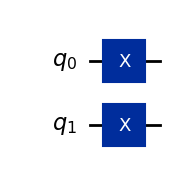

In [50]:
name_of_molecule = "CH4"
basis = 'sto3g' 

as_transform = (2,1)

fermionic_hamitltonian, problem = fermionic_hamiltonian_func(name_of_molecule, as_transform = as_transform)

circuit = HartreeFock(
    num_spatial_orbitals = problem[1].num_spatial_orbitals,
    num_particles = [problem[1].num_alpha,problem[1].num_beta],
    qubit_mapper = mapper_JW
)


print(problem[0].orbital_energies)
print(problem[1].orbital_energies)


print(problem[0].orbital_occupations)
print(problem[1].orbital_occupations)

print(problem[0].num_particles)
print(problem[1].num_particles)

print(problem[0].hamiltonian.constants)
print(problem[1].hamiltonian.constants)

circuit.draw('mpl')

## Fermionic Hamiltonian Exercises

### _Exercise 1_

#### Construct the fermionic Hamiltonian for $H_2$. Print it and classify the one electron and two electron terms.

In [8]:
fermionic_hamiltonian_H2, problem_H2 = fermionic_hamiltonian_func("H2")

print(fermionic_hamiltonian_H2[0])

Fermionic Operator
number spin orbitals=4, number terms=36
  0.33764838446774964 * ( +_0 +_0 -_0 -_0 )
+ 0.3321022196216439 * ( +_0 +_1 -_1 -_0 )
+ 0.33764838446774964 * ( +_0 +_2 -_2 -_0 )
+ 0.3321022196216439 * ( +_0 +_3 -_3 -_0 )
+ 0.09052603568449531 * ( +_0 +_0 -_1 -_1 )
+ 0.09052603568449531 * ( +_0 +_1 -_0 -_1 )
+ 0.09052603568449531 * ( +_0 +_2 -_3 -_1 )
+ 0.09052603568449531 * ( +_0 +_3 -_2 -_1 )
+ 0.09052603568449531 * ( +_1 +_0 -_1 -_0 )
+ 0.09052603568449531 * ( +_1 +_1 -_0 -_0 )
+ 0.09052603568449531 * ( +_1 +_2 -_3 -_0 )
+ 0.09052603568449531 * ( +_1 +_3 -_2 -_0 )
+ 0.3321022196216439 * ( +_1 +_0 -_0 -_1 )
+ 0.34908694289199416 * ( +_1 +_1 -_1 -_1 )
+ 0.3321022196216439 * ( +_1 +_2 -_2 -_1 )
+ 0.34908694289199416 * ( +_1 +_3 -_3 -_1 )
+ 0.33764838446774964 * ( +_2 +_0 -_0 -_2 )
+ 0.3321022196216439 * ( +_2 +_1 -_1 -_2 )
+ 0.33764838446774964 * ( +_2 +_2 -_2 -_2 )
+ 0.3321022196216439 * ( +_2 +_3 -_3 -_2 )
+ 0.09052603568449531 * ( +_2 +_0 -_1 -_3 )
+ 0.09052603568449531 *

### _Exercise 2_

#### Find the fermionic Hamiltonian of LiH and CH4 and count the number of terms. Print the Hamiltonians to see the number of terms

In [9]:
fermionic_hamiltonian_LiH,problem_LiH = fermionic_hamiltonian_func("LiH")

print(fermionic_hamiltonian_LiH[0])

Fermionic Operator
number spin orbitals=12, number terms=1860
  0.8293372983822359 * ( +_0 +_0 -_0 -_0 )
+ -0.05497644410772343 * ( +_0 +_0 -_1 -_0 )
+ -0.0694513704376929 * ( +_0 +_0 -_2 -_0 )
+ 0.0280235145327293 * ( +_0 +_0 -_5 -_0 )
+ -0.05497644410772343 * ( +_0 +_1 -_0 -_0 )
+ 0.18096570092037528 * ( +_0 +_1 -_1 -_0 )
+ 0.007154599662229467 * ( +_0 +_1 -_2 -_0 )
+ -0.02297454586433341 * ( +_0 +_1 -_5 -_0 )
+ -0.0694513704376929 * ( +_0 +_2 -_0 -_0 )
+ 0.007154599662229467 * ( +_0 +_2 -_1 -_0 )
+ 0.19772922851448527 * ( +_0 +_2 -_2 -_0 )
+ 0.008924637654695939 * ( +_0 +_2 -_5 -_0 )
+ 0.1981613496774764 * ( +_0 +_3 -_3 -_0 )
+ 0.19816134967747662 * ( +_0 +_4 -_4 -_0 )
+ 0.0280235145327293 * ( +_0 +_5 -_0 -_0 )
+ -0.02297454586433341 * ( +_0 +_5 -_1 -_0 )
+ 0.008924637654695939 * ( +_0 +_5 -_2 -_0 )
+ 0.18078732314199444 * ( +_0 +_5 -_5 -_0 )
+ 0.8293372983822359 * ( +_0 +_6 -_6 -_0 )
+ -0.05497644410772343 * ( +_0 +_6 -_7 -_0 )
+ -0.0694513704376929 * ( +_0 +_6 -_8 -_0 )
+ 0.028023

In [10]:
fermionic_hamiltonian_CH4,problem_CH4 = fermionic_hamiltonian_func("CH4")

print(fermionic_hamiltonian_CH4[0])

Fermionic Operator
number spin orbitals=18, number terms=21126
  1.7505278410028595 * ( +_0 +_0 -_0 -_0 )
+ -0.1467380973137759 * ( +_0 +_0 -_1 -_0 )
+ -0.16355510624004205 * ( +_0 +_0 -_8 -_0 )
+ -0.1467380973137759 * ( +_0 +_1 -_0 -_0 )
+ 0.354177866233202 * ( +_0 +_1 -_1 -_0 )
+ 0.14383841784616583 * ( +_0 +_1 -_8 -_0 )
+ 0.316953755168825 * ( +_0 +_2 -_2 -_0 )
+ 0.0580129717499512 * ( +_0 +_2 -_5 -_0 )
+ -0.05861298901323827 * ( +_0 +_2 -_6 -_0 )
+ 0.09426321458141979 * ( +_0 +_2 -_7 -_0 )
+ 0.316953755168825 * ( +_0 +_3 -_3 -_0 )
+ 0.04033201898458693 * ( +_0 +_3 -_5 -_0 )
+ 0.11022211103104061 * ( +_0 +_3 -_6 -_0 )
+ 0.04371447677872 * ( +_0 +_3 -_7 -_0 )
+ 0.31695375516882524 * ( +_0 +_4 -_4 -_0 )
+ 0.10341355979230035 * ( +_0 +_4 -_5 -_0 )
+ -0.010106668805513934 * ( +_0 +_4 -_6 -_0 )
+ -0.06992876298269111 * ( +_0 +_4 -_7 -_0 )
+ 0.0580129717499512 * ( +_0 +_5 -_2 -_0 )
+ 0.04033201898458693 * ( +_0 +_5 -_3 -_0 )
+ 0.10341355979230035 * ( +_0 +_5 -_4 -_0 )
+ 0.3656404753265601

### _Exercise 3_

#### How does the number of terms compare in these three cases? Consider what this means for the scaling of the Schrödinger equation for even larger molecular systems.

#### At most there will be $n^2$ one electron terms and $n^4$ two electron terms where n is the number of spin orbitals, which there never is because of symmetry. Therefore, we can see this as an upperbound for the number of terms. Larger molecules will include more spin orbitals and therefore the upperbound will increase. Each of these terms needs to be evaluated in the Schrödinger equation to find the energy, therefore the problem are getting increasingly complex with larger molecules.

# **Qubit Hamiltonian**

#### The fermionic Hamiltonian is not directly implementable on a quantum computer, as the operators cannot be programmed on quantum devices. Therefore, the operators are transformed into so called qubit operators through a fermionic to qubit mapper. There are a few different mappers such as the Jordan-Wigner and B^ravyi-Kitaev, we will mainly be focusing on the Jordan-Wigner mapper. It works by turning the operators into tensor products of Pauli matrices, the details are not important as all the necessary transformation are done through qiskit. However, when the fermionic Hamiltonian is transfromed through a mapper to the qubit Hamiltonian it will represented as a sum of coefficients and Pauli strings,
#### $\hat{H}_{e} = \sum_{i, j}h_{ij}\hat{a}_i^\dagger \hat{a}_j + \sum_{p, q, r, s} g_{pqrs} \hat{a}_p^\dagger \hat{a}_q^\dagger \hat{a}_r \hat{a}_s \xrightarrow{\text{mapper}} \hat{H} = \sum_i c_i \mathcal{P}_i$
#### To start let us define the different mappers by their abbreviation:

In [11]:
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper, BravyiKitaevSuperFastMapper

mapper_JW = JordanWignerMapper()

mapper_P = ParityMapper()

mapper_BK = BravyiKitaevMapper()

mapper_BKSF = BravyiKitaevSuperFastMapper() 

#### Let us define a function which takes the name of a molecule as input and returns the qubit Hamiltonian along with the electron structure problem. This function can also take the basis set functions, the active space transformation and a fermionic to qubit mapper, but these are set to the default value of basis = STO-3G, full active space and the Jordan-Wigner mapper.

In [12]:
def qubit_hamiltonian_func(name_of_molecule, basis = 'sto3g', as_transform = 0, mapper = mapper_JW):
    ''' 
    Construct qubit Hamiltonian and electronic structure problem from molecule name.
    Optional inputs are basis set, active space transformer and fermionic to qubit mapper.
    '''
    fermionic_hamiltonian, problem = fermionic_hamiltonian_func(name_of_molecule,basis,as_transform)

    qubit_hamiltonian = [mapper.map(hamiltonian) for hamiltonian in fermionic_hamiltonian]
    
    return qubit_hamiltonian, problem

## Qubit Hamiltonian Exercise

### _Exercise 1_

####  Construct the qubit Hamiltonian of $H_2$ in the STO-3g basis using the Jordan-Wigner mapper. Print the qubit Hamiltonian. How do you interpret this Hamiltonian?
#### Print the qubit Hamiltonian like so, 
for i in qubit_hamiltonian[0]:
    
    print(i.coeffs,i.paulis)

In [13]:
qubit_hamiltonian_H2, problem_H2 = qubit_hamiltonian_func("H2")

#To make it more readable let us print the Pauli strings along with the coefficients like so
for i in qubit_hamiltonian_H2[0]:
    print(i.coeffs,i.paulis)

[-0.81125571+0.j] ['IIII']
[0.17184932+0.j] ['IIIZ']
[-0.2247445+0.j] ['IIZI']
[0.12078809+0.j] ['IIZZ']
[0.17184932+0.j] ['IZII']
[0.16882419+0.j] ['IZIZ']
[-0.2247445+0.j] ['ZIII']
[0.16605111+0.j] ['ZIIZ']
[0.04526302+0.j] ['YYYY']
[0.04526302+0.j] ['XXYY']
[0.04526302+0.j] ['YYXX']
[0.04526302+0.j] ['XXXX']
[0.16605111+0.j] ['IZZI']
[0.17454347+0.j] ['ZIZI']
[0.12078809+0.j] ['ZZII']


#### In contrast with the fermionic Hamiltonian all the Pauli strings are of the same length and correspond to different kinds of interactions, split into interactions which are described by one Slater determinant and interactions where two is needed. There are many things to conclude from this Hamiltonian, firstly we see that there are terms which contain I and Z matrices and terms which contain X and Y matrices. These two different kinds of terms correspond to different kinds of interactions between electrons. The terms containing X and Y matrices correspond to correlation interactions, as they require two Slater determinants to have a non zero expectation value.

### _Exercise 2_

#### Count the number of terms and the length of the strings in the Hamiltonian.

In [14]:
print('Number of terms:',len(qubit_hamiltonian_H2[0]))
print('Length of strings:',len(qubit_hamiltonian_H2[0].paulis[0]))

Number of terms: 15
Length of strings: 4


### _Exercise 3_

#### It is possible to see how many qubits are needed to describe a system with a given Hamiltonian. This can be done by using the following command:
#### print(qubit_hamiltonian.num_qubits)
#### How many qubits are needed to describe H2 and why?

In [15]:
print(qubit_hamiltonian_H2[0].num_qubits)

4


#### Since we use a direct mapping of occupation states onto qubits, each spin orbitals then requires a qubit. $H_2$ in the STO-3G basis has 4 spin orbitals and therefore also 4 qubits are needed to describe it.

### _Exercise 4_
#### How many qubits are needed to describe LiH or CH4 and why?

In [16]:
qubit_hamiltonian_LiH, problem_LiH = qubit_hamiltonian_func("LiH")
qubit_hamiltonian_CH4, problem_CH4 = qubit_hamiltonian_func("CH4")
print('number of qubits for LiH:', qubit_hamiltonian_LiH[0].num_qubits)
print('number of qubits for CH4:', qubit_hamiltonian_CH4[0].num_qubits)

number of qubits for LiH: 12
number of qubits for CH4: 18


# **Initializing Hartree-Fock State**

#### The Hartree-Fock (HF) method approximates the many body electrons problem into a one electron problem where electron-electron repulsion is treated in an averaged way. This leads to the HF equation which can be solved through an iterative process to find the HF ground state. This state is described by a single Slater determinant, for $H_2$ in the STO-3G basis the HF ground state is where both electrons are in bonding orbital. This correpsonds to a state vector which has two electrons (or 1's) in the bonding orbitals. In the following cell a function which initializes a circuit to include the right amount of qubits corresponding to the qubit Hamiltonian is defined. The exercises are meant to built intution for how these state vectors represent chemical states.

In [17]:
from qiskit.quantum_info import Statevector

def initialize_circuit(name_of_molecule, basis = 'sto3g', as_transform = 0, mapper = mapper_JW):
    """
    Creates a quantum circuit matching the number of qubits used in qubit Hamiltonian
    """
    qubit_hamiltonian, problem = qubit_hamiltonian_func(name_of_molecule, basis, as_transform, mapper)

    circuit = [QuantumCircuit(hamiltonian.num_qubits) for hamiltonian in qubit_hamiltonian]
        
    return circuit

## Initializing HF state exercises

### _Exercise 1_

#### Initialize a quantum circuit for the qubit Hamiltonian for $H_2$.
#### Print the quantum circuit by using: Statevector(circuit).draw(output = 'latex') where ”circuit” is the name of the circuit you just defined.

In [18]:
circuitH2 = initialize_circuit("H2")[0]

Statevector(circuitH2).draw(output = 'latex')

<IPython.core.display.Latex object>

### _Exercise 2_

#### Add an electron in the two bonding orbitals to initialize an HF-state. X gates are implemented by: circuit.x(i) where i is index of the qubit.

In [19]:
circuitH2.x(0)
circuitH2.x(2)

Statevector(circuitH2).draw(output = 'latex')

<IPython.core.display.Latex object>

### _Exercise 3_

#### Initialize another circuit and add two electrons in the two anti-bonding orbitals. (Hint: call this circuit something else than the previous circuit. Then you can continue working with both of them later)

In [20]:
circuitH2a = initialize_circuit("H2")[0]

circuitH2a.x(1)
circuitH2a.x(3)

Statevector(circuitH2a).draw(output = 'latex')

<IPython.core.display.Latex object>

# **Run The VQE Without Parameters**

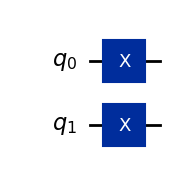

In [23]:
name_of_molecule = "CH4"
as_transform = (2,1)

fermionic_hamitltonian, problem = fermionic_hamiltonian_func(name_of_molecule, as_transform = as_transform)

circuit = HartreeFock(
    num_spatial_orbitals = problem[1].num_spatial_orbitals,
    num_particles = [problem[1].num_alpha,problem[1].num_beta],
    qubit_mapper = mapper_JW
)

circuit = [HartreeFock(prob.num_spatial_orbitals, [prob.num_alpha,prob.num_beta], mapper_JW) for prob in problem]

circuit[1].draw('mpl')

#### The variational quantum eigensolver (VQE) utilizes the variational principle to find the ground state energy on both a quantum computer and classical computer. The expectatian value of the Hamiltonian is calculated on a quantum device for a given trial function which is parameterized by some variables then these variables are minimized on a classical computer. Here we will try first just to calculate the expectation value of the qubit Hamiltonian for different molecules without the wave function being parameterized and later try to run it with parameters.

#### It is generally not trivial to create the HF groundstate for different molecules, luckily qiskit nature has a function which will initialize the HF ground state for us. In the following cell a function which initializes the HF ground state is defined, it takes the molecule name as input and output a quantum circuit. Additionally, it also have options of choicing basis set functions, the active space and fermionic to qubit mapper, which is in their default settings when not specified.

In [22]:
from qiskit_nature.second_q.circuit.library import HartreeFock

def HF(name_of_molecule, basis = 'sto3g', as_transform = 0, mapper = mapper_JW, use_problem = 0):
    """ 
    Prepares HF ground state of molecule in given basis.
    If no mapper is chosen uses Jordan-Wigner.
    """
    if use_problem:
        problem = use_problem
    else:
        qubit_hamiltonian, problem = qubit_hamiltonian_func(name_of_molecule, basis, as_transform, mapper)

    circuit = [HartreeFock(prob.num_spatial_orbitals, [prob.num_alpha,prob.num_beta], qubit_mapper = mapper_JW) for prob in problem]
        
    return circuit

#### There are two parts to running the VQE (without the parameterization), calculating the expectation value (or measuring) and minimizing parameters. Below we define a function which calculates the expectation value of a Hamiltonian with an ansatz on a simulated quantum computer. This function is part of the VQE function defined below it and will not be used on its own.

In [24]:
from qiskit.primitives import StatevectorEstimator

def expectation_value(params, ansatz, hamiltonian):
    """
    Calculates expectation value, works with vqe function.
    """
    pub = (ansatz, [hamiltonian], [params])
    
    estimator = StatevectorEstimator()
    
    result = estimator.run(pubs=[pub]).result()
    
    energy = result[0].data.evs[0]

    return energy

#### The VQE function requires the name of a molecule as its input, which it then constructs the qubit Hamiltonian for and if no parameterized circuit is given then the expectation energy of the HF ground state is calculated, it returns the optimal energy and optimal parameters. The basis set, active space and fermionic to qubit mapper is optional settings, and are set to default values. Additionally, a circuit can be added which lets you calculate different energies than the HF ground state energy, eventually we will add a parameterized circuit here.

In [25]:
from scipy.optimize import minimize

def vqe(name_of_molecule, basis = 'sto3g', as_transform = 0, mapper = mapper_JW, circuit = None):
    """ 
    Calculates optimized energy based on molecule name and basis info.
    If no parameters are used returns HF ground state expectation energy.
    Can include a circuit, if not HF ground state is used.
    """
    qubit_hamiltonian, problem = qubit_hamiltonian_func(name_of_molecule, basis, as_transform, mapper)

    if circuit:
        ansatz = circuit
    else:
        ansatz = HF(name_of_molecule, basis, as_transform, mapper)

    num_params = [ans.num_parameters for ans in ansatz]
    
    if num_params[0] == 0:
        optimal_param = []  
        energy = [expectation_value(optimal_param, ansatz[0], qubit_hamiltonian[0])]
            
    else: 
        x0 = 2 * np.pi * np.random.random(num_params[0])
    
        result = minimize(
                expectation_value,
                x0,
                args=(ansatz[0], qubit_hamiltonian[0]),
                method="SLSQP"
            )
        
        energy = [result.fun] 
        optimal_param = [result.x]
        
    if len(ansatz) > 1:
        energy.append(expectation_value(optimal_param, ansatz[1], qubit_hamiltonian[1]))
        optimal_param.append(0)
        
    return energy, optimal_param

## _VQE Without Parameters Exercises_

### _Exercise 1_

#### Run the VQE for the Hartree-Fock ground state to find the expectation energy.

In [26]:
energy_H2_HF, optimal_param_H2_HF = vqe("H2")

energy_H2_HF

[-1.8347540817827495]

### _VQE Exercise 2_

#### Use the anti-bonding state as your circuit instead and calculate the expectation value using the VQE

In [30]:
circuitH2a = initialize_circuit("H2")[0]
circuitH2a.x(1)
circuitH2a.x(3)

circuitH2a = [circuitH2a]

vqe("H2", circuit = circuitH2a)[0]

[-0.2483788131581525]

# **Exact Energy**

#### For small molecules, like $H_2$ we are able to exactly diagonalize the Hamiltonian giving us the exact energy. Eventhough we say this is the exact energy, it is only the exact energy of the chosen basis. Throughout this problem set we have worked with a minimal basis, for more precise energy calculations we should use larger basis sets. For larger molecules or basis sets the exact diagonalization becomes practicly impossible since the matrix which describes the Hamiltonian gets more complex. The details of how to calculate the exact energy is skipped here, since we will be using numpys minimum eigensolver. In the following cell a function which calculates the exact energy given a molecule name is defined. The choice of basis set, active space an fermionic to qubit mapper is optional.

In [31]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

def exact_energy(name_of_molecule, basis = 'sto3g', as_transform = 0, mapper = mapper_JW):
    """ 
    Calculates the exact diagonalization of a Hamiltonian.
    Returns the eigenvalues of Hamiltonian.
    """
    qubit_hamiltonian, problem = qubit_hamiltonian_func(name_of_molecule, basis, as_transform, mapper)

    exact_calc = GroundStateEigensolver(mapper, NumPyMinimumEigensolver())

    exact_result = [exact_calc.solve(prob).eigenvalues for prob in problem]

    return exact_result

## _Exact Energy Exercises_

### _Exercise 1_

#### Find the exact energy for $H_2$ in the STO-3G basis.

In [32]:
exact_energy_H2 = exact_energy("H2")[0]

exact_energy_H2

array([-1.85515509])

### _Exercise 2_

#### Compare the exact energy with the HF ground state energy. Why is there a descreptancy between these two energies?

In [33]:
exact_energy_H2-energy_H2_HF

array([-0.02040101])

#### The HF ground state does not include all the terms of the exact wave function and are there incapable of describing all interactions of the molecule.

### _Exercise 3_

#### The Coulomb correlation increases as a function of inter nuclei distance for $H_2$ in the STO-3G basis. Define a function which calculate the energy difference between the exact ground state and the HF ground state. Use this function to show that the Coulomb correlation increases with inter nuclei distance and plot it using matplotlib.pyplot.

In [34]:
def vqe_and_exact_result_inter_nuclei_distance(
    name_of_molecule, internucleidistance, basis = 'sto-3g', mapper = mapper_JW):
    
    Molecule = molecule(name_of_molecule)  

    atom_list = Molecule.get_chemical_symbols()

    position_list = Molecule.positions*internucleidistance

    qiskitmolecule = MoleculeInfo(atom_list,position_list)

    #Fermionic Hamiltonian
    driver_mol = PySCFDriver.from_molecule(qiskitmolecule, basis=basis)
    
    problem = driver_mol.run()
    
    fermionic_hamiltonian = problem.hamiltonian.second_q_op()

    #Qubit Hamiltonian
    qubit_hamiltonian = mapper.map(fermionic_hamiltonian)

    #exact energy
    exact_calc = GroundStateEigensolver(mapper, NumPyMinimumEigensolver())
    
    exact_result = exact_calc.solve(problem).eigenvalues

    #vqe result
    circuit = HartreeFock(problem.num_spatial_orbitals,[problem.num_alpha,problem.num_beta],mapper)
    optimal_param = []

    vqe_result = expectation_value(optimal_param, circuit, qubit_hamiltonian)
    
    return vqe_result, exact_result

Text(0, 0.5, 'Energy Difference [Hartree]')

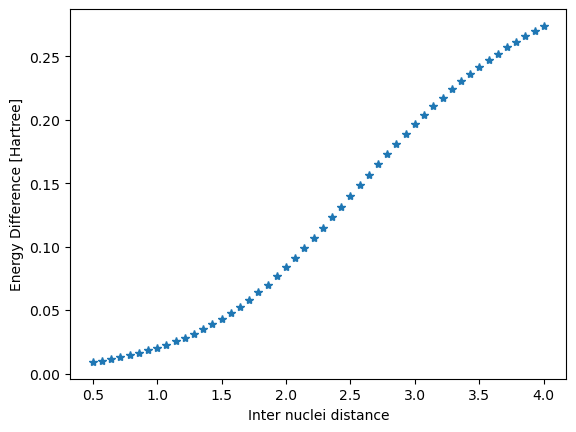

In [35]:
import matplotlib.pyplot as plt

r = np.linspace(0.5,4,50)

energy_difference_array = []

for i in r:
    vqe_result, exact_result = vqe_and_exact_result_inter_nuclei_distance("H2",i)

    energy_difference_array.append(vqe_result-exact_result[0])

plt.plot(r,energy_difference_array,'*')
plt.xlabel('Inter nuclei distance')
plt.ylabel('Energy Difference [Hartree]')

# **VQE With Parameters**

#### Above we defined functions which can run the VQE for us but we are missing the last step, parameterization of the wave function. To parameterize we will use the unitary coupled cluster ansatz with single and double excitations. Below a function which parameterizes a circuit for a given molecule such that it can explore a large enough Hilbert space to eventually converge to the exact ground state. This function returns the result of the VQE function, a state vector and the circuit which it parameterised. This function has optional parameters of basis set, active space and fermionic to qubit mapper. Also the types of excitations are also optional, if you e.g. only wish to look at double excitations, and the perservation of spin symmetry can also be disabled.

In [38]:
from qiskit_nature.second_q.circuit.library import UCC

def vqe_ucc(name_of_molecule, basis = 'sto3g', as_transform = 0, mapper = mapper_JW, excitations = 'sd', preserve_spin = True):
    """
    Calculates the variationally optimized energy using the UCCSD as standard, excitations can be changed to only include single or double.
    Uses the Hartree-Fock ground state as initial state and returns the optimized circuit as a Statevector.
    """
    qubit_hamiltonian, problem = qubit_hamiltonian_func(name_of_molecule, basis, as_transform, mapper)

    HF_circuit = HF(name_of_molecule, basis, as_transform, mapper)

    circuit = [UCC(
        num_spatial_orbitals = problem[0].num_spatial_orbitals, 
        num_particles = problem[0].num_particles, 
        excitations = excitations, 
        qubit_mapper = mapper, 
        initial_state = HF_circuit[0],
        preserve_spin = preserve_spin
    )]

    if len(HF_circuit) > 1:
        circuit.append(HF_circuit[1])
    
    vqe_result = vqe(name_of_molecule, basis, as_transform, mapper, circuit)
    
    state = [Statevector(circuit[i].assign_parameters(vqe_result[1][i])) for i in range(len(circuit))]

    return vqe_result, state, circuit
    #return vqe_result, circuit
    #return circuit

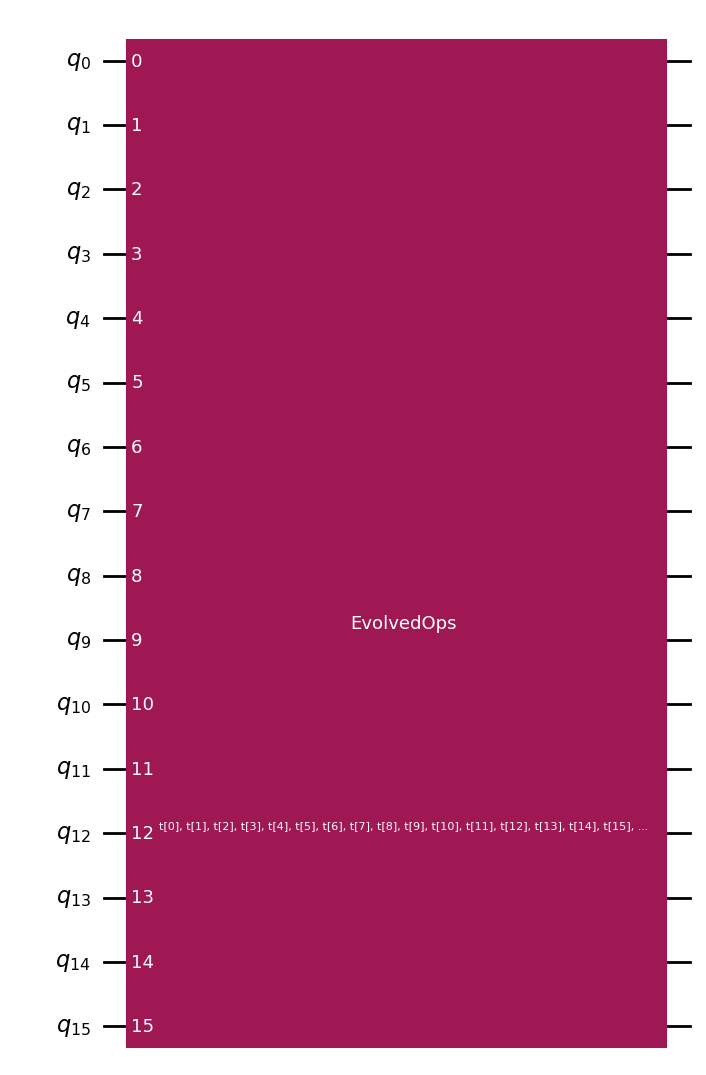

In [93]:
name_of_molecule = "CH4"
as_transform = (2,1)

circuit = vqe_ucc(name_of_molecule,as_transform = as_transform)

circuit[0].draw('mpl')

## _VQE With Parameters Exercises_

### _VQE With Parameters Exercise 1_

#### Run the VQE for the $\text{H}_2$ molecule with the UCCSD prepared ansatz, find the energy difference between with the exact energy and print the state vector. Why is not the correct state and what can you change to correct it?

In [42]:
vqe_result, state, circuit = vqe_ucc("H2")

print("Energy difference:", exact_energy("H2")[0]-vqe_result[0])

state[0].draw(output='latex')

Energy difference: [-2.08395126e-08]


<IPython.core.display.Latex object>

#### Here we see that the energy difference is negligible but the state includes single excitations, which is not included in the describition of the molecule.

### _VQE with params exercise 2_

#### Run the VQE using an ansatz where you use UCC with only double excitations, by setting 
    excitations ='d'

#### Then print

    circuit.decompose().draw('mpl')

#### What does this tell you?

VQE Energy: [-1.855155087859009]
Energy difference: [-2.23354668e-12]


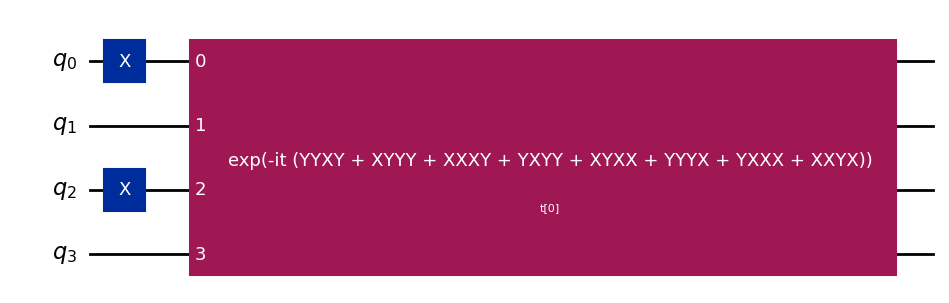

In [45]:
vqe_result, state, circuit = vqe_ucc("H2", excitations = 'd')

print("VQE Energy:" , vqe_result[0])
print("Energy difference:", exact_energy("H2")[0]-vqe_result[0])

circuit[0].decompose().draw('mpl')

#### These are the Pauli products which correspond to a double excitation, each excitation needs a product of four Pauli matrices and there are eight equivalent Pauli products.

# Different basis sets WORK IN PROGRESS

In [47]:
molec = "H2O"
as_transform = (2,2)

vqe_result, state, circuit = vqe_ucc(molec, as_transform = as_transform)

exact_result = exact_energy(molec)

ValueError: Length of () inconsistent with last dimension of [[[ 0.08098608  6.06236326  4.70747857  3.5610513   2.15299265
    4.71489687  4.69549744  4.73245724  1.83912578  4.71087927
    3.28516496  2.23572736  2.53827248  1.01344025  2.78789518
    0.93488721  2.83451527  5.14239169  1.33117397  1.60075003
    3.10470805  0.93420618  3.43979254  3.07470595 -0.09126747
    0.37916729  1.3767728   5.01769651  2.37897917  0.26590174
    5.40026045  3.66872334  0.36861036  0.5400131   0.09108228
    5.7291693   3.03934006 -0.1494179   1.58530537  2.41708847
    4.71697557  4.81018412  3.92243705  4.51123762  2.23527695
    5.09912726  4.59850764  4.65544601  4.5893623   4.52294976
    1.61227335  1.55534218  6.27151204  6.28342424]]]

In [ ]:
print("Energy difference:", exact_result[0]-vqe_result[0])

state[0].draw(output='latex')

In [46]:
molec = "LiH"
basis = 'sto-3g'
as_transform = (2,2)

ferminionc_hamiltonian, problem = fermionic_hamiltonian_func(molec,basis, as_transform)

vqe_result, state, circuit, problem = vqe_ucc(molec, basis, as_transform = as_transform, excitations = 'sd', preserve_spin = False)

print("VQE Energy:" , vqe_result[0])
print("Reference Energy:", problem.reference_energy)
print("VQE Energy + Reference Energy:", vqe_result[0]+problem.reference_energy)
print("Exact Energy (not reduced):", (exact_energy(molec,basis)))
#print("HF ground state energy:", vqe(molec, basis)[0])
#print("Energy difference:", np.real(exact_energy(molec,basis)-vqe_result[0]))
print("HF ground state energy: -8.897849719021995")

#print(problem.num_particles)
#state.draw(output='latex')

ValueError: The number of qubits of the circuit (0) does not match the number of qubits of the (0,)-th observable (8).

In [40]:
molec = "LiH"
basis = 'sto3g'
as_transform = ((2,2),6)

vqe_result, state, circuit = vqe_ucc(molec, basis, as_transform = as_transform, excitations = 'sd', preserve_spin = False)

print("VQE Energy:" , vqe_result[0])
print("Exact Energy (not reduced):", (exact_energy(molec,basis)))
print("HF ground state energy:", vqe(molec, basis))
print("Energy difference:", np.real(exact_energy(molec,basis)-vqe_result[0]))

state.draw(output='latex')
#circuit.decompose().draw('mpl')

KeyboardInterrupt: 

## Exact energy in different bases

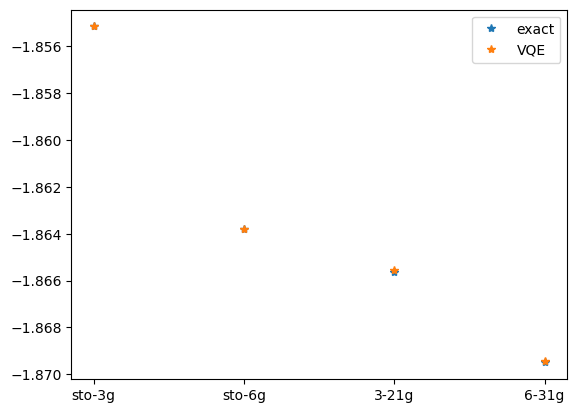

In [86]:
import matplotlib.pyplot as plt

bases = ['sto-3g','sto-6g','3-21g','6-31g']
molec = "H2"

exact_energy_array = []
vqe_result_array = []

for i in bases:
    exact_energy_array.append(np.real(exact_energy(molec, i)))
    vqe_result, state, circuit = vqe_ucc(molec, i, excitations = 'd')
    vqe_result_array.append(vqe_result[0])

plt.plot(bases,exact_energy_array,'*', label = 'exact')
plt.plot(bases,vqe_result_array,'*',label ='VQE')
plt.legend()

In [75]:
problem_CH4.num_spin_orbitals

18

In [77]:
2**18

262144